#Title: AE-DBSCAN – An Outlier Detection Method on Multidimensional Tabular Datasets.


###By: Ademide (Midé) Mabadeje

Let's install the packages needed for the code demonstrations below and import accordingly.

In [1]:
import numpy as np
import pandas as pd
import random as rand
import copy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

from torchvision import datasets
from torchvision import transforms

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Declare and define the functions needed for computational ease.

In [3]:
def norm(bhp_mon):
    """
    A function to normalize the input array on [0, 1] that returns a normalized 
    input array.

    Parameters

    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    test_norm=(bhp_mon-min_p)/(max_p-min_p)
    return test_norm

def inv_norm(norm_array,bhp_mon):
    """
    A function to invert the normalized input array back to its original scale 
    in Euclidean space.

    Parameters

    norm_array: a normalized nd-array 
    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    inv_norm=norm_array*(max_p-min_p)+min_p
    return inv_norm
    
def norm_2(norm_array,bhp_mon):
    """
    A function to normalize the input array based on a specific range or 
    different vector in Euclidean space on a scale of [0, 1]

    Parameters

    norm_array: a normalized nd-array 
    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    test_norm=(norm_array-min_p)/(max_p-min_p)
    return test_norm


def nearest_neighbor(X, Ax=None, Ay=None, T=None, plotter=True):
    """
    A function to find the most prevalent intersampling distance (lag dist) in 
    an array
    
    Parameters
    X: an array of the dataset consisting of a point sets location vectors
    """
    
    # Input preparation
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # get nominal distance between samples such that it can be used as lag_distance input
    lag_dist = np.mean(distances)

    if plotter:
      # Make figure
      plt.plot(distances, c='black')
      plt.xlabel('Sorted Ascending, Data Index')
      plt.ylabel('Intersample Distance in LS')
      plt.title('Nearest Neighbour ')
      plt.plot(Ax, Ay, color='black', linestyle='--')
      plt.text(T[0], T[1], r'Elbow location with optimal epsilon', size=10)
      plt.savefig('Eps determination in LS using NN.tiff', dpi=300, bbox_inches='tight')
      plt.show()
    return lag_dist

Affix the random seed in Pytorch to ensure reproducible results.

In [4]:
seed = 78703
torch.manual_seed(seed)

Create a multidimensional from the same standard normal distribution randomly for four predictor feature at a random seed and normalize.

In [5]:
np.random.seed (73073) # set seed
X = np.random.normal(loc=0, scale=1, size=3000*4).reshape(-1,4) # Create a multidimensional from the same standard normal distribution randomly for four predictor features
X_n=norm(X) # Find the normalized version of the array
print(f'X shape = {X_n.shape}')

X shape = (3000, 4)


Split the synthetic multidimensional dataset into test and train sets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_n, X_n, test_size=0.20, random_state=42) # Split the generated normalized toy/synthetic dataset using a test size of 20%

Prepare the synthetic dataset such that it is in a Pytorch accepted format with the earlier test-train split sets. 

In [7]:
class GaussianDataset(Dataset): # Define the class to run instantiate split datasets into pytorch format
    def __init__(self, X, device, clazz=0):
        self.__device = device
        self.__clazz = clazz
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        item = self.__X[idx,:]

        return item, self.__clazz

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset_train = GaussianDataset(X=X_train, device=device)
dataset_test = GaussianDataset(X=X_test, device=device)
data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=1)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True, num_workers=1)

cuda


Build the Autoencoder (AE) architecture as needed using feed-forward layers.

In [8]:
class AE(torch.nn.Module): # Build the Autoencoder architecture needed
    def __init__(self, input_size):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 2)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Initialize the AE model and specify trhe loss function and optimizer to use i.e., MSE and ADAM respectively.

In [9]:
model = AE(input_size=X.shape[1]).double().to(device) # Set up AE model
loss_function = torch.nn.MSELoss(reduction='mean').to(device) # loss fn estimation using MSE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8) # Adam optimizer

Train the built AE over a large number of epochs such that it is well trained and would work well at reconstructing X = X' in the test set.

In [10]:
# Train built AE over a large enough number of epochs such that the AE is well trained such that X = X'
epochs = 100
history = dict(train=[], val=[])
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0

for epoch in range(epochs):
    model = model.train()
    train_losses = []

    for (items, _) in data_loader_train:
        optimizer.zero_grad()
        items = items.to(device)

        reconstructed = model(items)
        loss = loss_function(reconstructed, items)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().cpu().numpy().item())

    train_losses = np.array(train_losses)

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for (items, _) in data_loader_test:

        items = items.to(device)
        reconstructed = model(items)
        loss = loss_function(reconstructed, items)

        val_losses.append(loss.detach().cpu().numpy().item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)

Epoch 0: train loss 0.05395905431087682 val loss 0.017122801235424232
Epoch 1: train loss 0.015547166562780641 val loss 0.013768349963898176
Epoch 2: train loss 0.012560434635663227 val loss 0.013120648446727666
Epoch 3: train loss 0.01237962035461118 val loss 0.012902282264112308
Epoch 4: train loss 0.01233463615397863 val loss 0.012922078069226727
Epoch 5: train loss 0.012350081303388287 val loss 0.013092538983569322
Epoch 6: train loss 0.012485094959805744 val loss 0.013119332824344439
Epoch 7: train loss 0.0124314319428288 val loss 0.01293160035321162
Epoch 8: train loss 0.01242819822183333 val loss 0.012967010856291357
Epoch 9: train loss 0.012392291740176784 val loss 0.013119808541205093
Epoch 10: train loss 0.01242109078581059 val loss 0.0129479478291688
Epoch 11: train loss 0.012441255710419775 val loss 0.013392264331243277
Epoch 12: train loss 0.012386690699700095 val loss 0.013018465178441898
Epoch 13: train loss 0.01240168952291846 val loss 0.012965307978972109
Epoch 14: tra

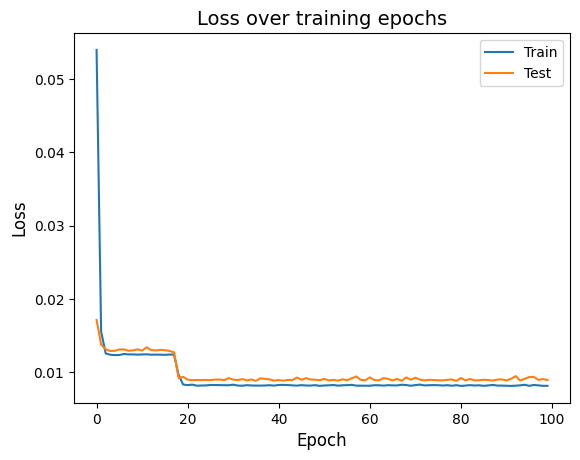

In [11]:
## Save the tuned trained model 
# MODEL_PATH = 'ML_anomality_detection.pth'
# torch.save(model, MODEL_PATH)

# Make visual for loss in train and test datasets
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Test'])
plt.title('Loss over training epochs', fontsize=14)
plt.savefig("Loss over training epochs same random population.tiff", dpi=300)
plt.show();

Measure the reconstruction error on the predictor features to see if X_test = (X_test)' or by how much it differs.

In [12]:
test_score=[]
test_pred=[]
test_real=[]
for j in range(X_test.shape[0]):
  test=torch.tensor(X_test[j]).to(device)
  pred=model(test).detach().cpu().numpy()

  inv_pred=inv_norm(pred,X)
  test_pred.append(inv_pred)

  inv_test=inv_norm(X_test[j],X)
  test_real.append(inv_test)

  mse=mean_squared_error(inv_test,inv_pred)
  test_score.append(mse)

test_score=np.array(test_score)
test_pred=np.array(test_pred)
test_real=np.array(test_real)

Visualize the predicted values with the actual values and compare using a 45 degree line as a measure of total accuracy if data points lie exactly on it.

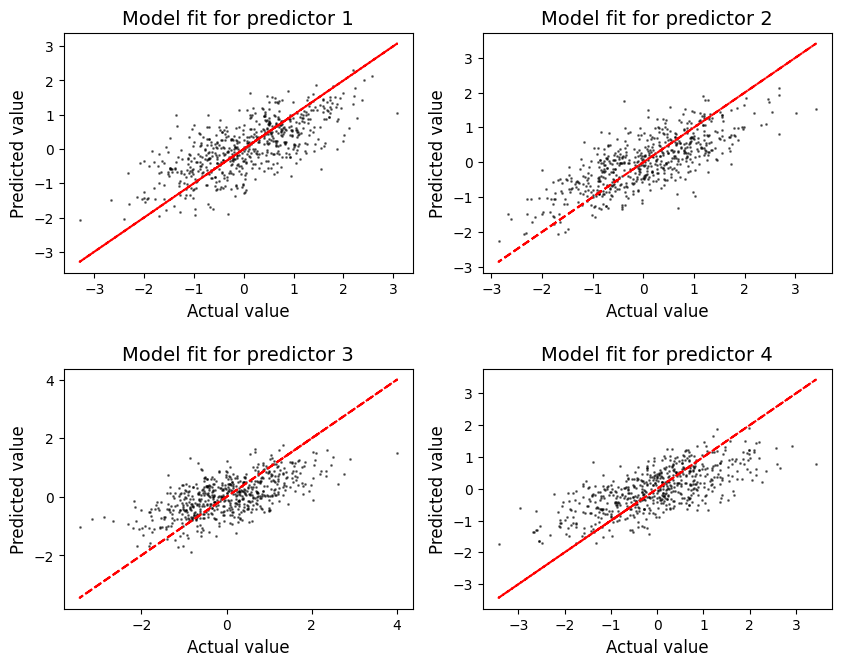

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2)

for k, ax in enumerate(axs.flatten()):
  ax.scatter(test_real[:,k],test_pred[:,k], alpha=0.5, color='k', s=1)
  ax.plot(test_real[:,k],test_real[:,k], color='red', linestyle='--')
  ax.set_xlabel('Actual value', fontsize=12)
  ax.set_ylabel('Predicted value', fontsize=12)
  ax.set_title(f"Model fit for predictor {k+1}", fontsize=14)

plt.savefig("Model fit over same random population.tiff", dpi=300)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.4)
plt.show();

In [14]:
output = inv_pred
input = inv_test

print('The reconstructed input, output differs from the original AE input by the following differences: ' , np.round(input-output,4), '\n, hence we do not have perfect reconstruction between the input and output')

The reconstructed input, output differs from the original AE input by the following differences:  [-0.0425 -0.8334  0.9755  0.1654] 
, hence we do not have perfect reconstruction between the input and output


In [15]:
print('The array for the input is: ', np.round(inv_test, 4))
print('The array for the output is: ', np.round(inv_pred, 4))

The array for the input is:  [-0.6525 -0.4977  1.3167 -0.4175]
The array for the output is:  [-0.61    0.3357  0.3412 -0.5829]


Obtain the data projections in the latent space 

In [16]:
# Obtain the data projections in the latent space
latent_space=[]
mse_dst=[]
for i in range(X_n.shape[0]):
  test=torch.tensor(X_n[i]).to(device)

  lat=model.encoder(test).detach().cpu().numpy()
  latent_space.append(lat)

  pred=model(test).detach().cpu().numpy()
  
  inv_pred=inv_norm(pred,X)
  inv_test=inv_norm(X_n[i],X)

  mse=mean_squared_error(inv_test,inv_pred)
  mse_dst.append(mse)

latent_space=np.array(latent_space)
mse_dst=np.array(mse_dst)

Visualize the latent space with the originally trained dataset.





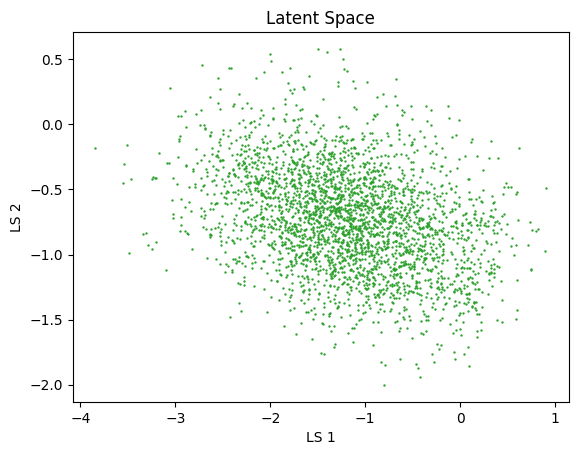

In [17]:
#Visualize latent space with originally trained data
plt.title('Latent Space')
plt.scatter(latent_space[:,0],latent_space[:,1],s=0.5,color='C2')
plt.xlabel('LS 1')
plt.ylabel('LS 2');
plt.savefig("Latent space visualization.tiff", dpi=300)
plt.show();

# Outlier Identification for High-dimensional Datasets using MSE threshold


Basically, we identify the 95% upper bound MSE value from the MSE cumulative distribution in the latent space. Then, points exceeding this MSE threshold value are dubbed as outlier points (See the report for appropriate reference).

<br>

Visualize the MSE distribution, which follows a one tailed chi-square distribution.

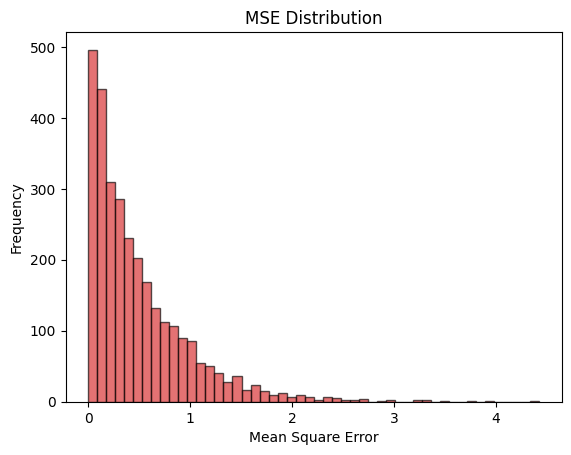

In [18]:
# Visualize the MSE distribution which follows a one tailed, chisquare dbn
plt.hist(mse_dst,bins=50,color='C3',edgecolor='k', alpha=0.65)
plt.title('MSE Distribution')
plt.xlabel('Mean Square Error')
plt.ylabel('Frequency');
plt.savefig("MSE training distribution LS.tiff", dpi=300)
plt.show();

Find the 95% MSE Upper bound value from the CDF of the MSE distribution and use as a threshold, which is similar to existing NN outlier detection methods.  

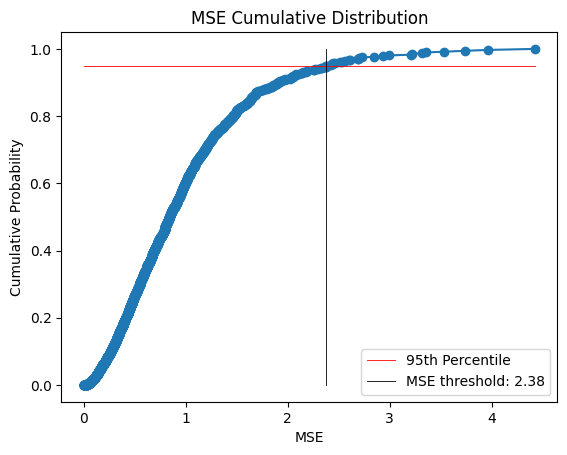

In [19]:
# Obtain and visualize the 95% MSE value from the CDF of the MSE dbn
sorted_data = np.sort(mse_dst)
cumulative_sum = np.cumsum(sorted_data)

cdf = cumulative_sum / np.sum(sorted_data)

prob_th=0.95
loc_abn=np.where(cdf>prob_th)
abn_mse=sorted_data[loc_abn]
mse_th=abn_mse[0]

# Plot the CDF
plt.scatter(sorted_data, cdf)
plt.plot(sorted_data, cdf)
plt.plot([0,np.max(mse_dst)],[0.95,0.95],color='red',linewidth=0.6,label="95th Percentile")
plt.plot([mse_th,mse_th],[0,1],color='black',linewidth=0.6,label='MSE threshold: '+str(round(mse_th,2)))
plt.xlabel('MSE')
plt.ylabel('Cumulative Probability')
plt.title('MSE Cumulative Distribution')
plt.legend(loc='lower right')
plt.savefig("MSE LS CDF with threshold.tiff", dpi=300)
plt.show()

Generate abnormal points to be embedded in the existing latent space using the well trained encoder. Realize, even though noisy, not all abnormal points are outliers as some may actually belong to the inlier population. This phenomenon is seen in subsequent figures during method comparisons, and alludes to the limits of using synthetic unlabelled dataset.

In [20]:
np.random.seed (73073) # set seed
X_abn = np.random.normal(loc=5, scale=5, size=56).reshape(-1,4)
X_abn_n=norm_2(X_abn,X)


abn_latent_space2=[]
mse_abn2=[]
for i in range(X_abn_n.shape[0]):
  test_abn=torch.tensor(X_abn_n[i]).to(device)

  lat=model.encoder(test_abn).detach().cpu().numpy()
  abn_latent_space2.append(lat)

  pred=model(test_abn).detach().cpu().numpy()
  inv_pred=inv_norm(pred,X)
  inv_test=inv_norm(X_abn_n[i],X)

  mse=mean_squared_error(inv_test,inv_pred)
  mse_abn2.append(mse)

abn_latent_space2=np.array(abn_latent_space2)
mse_abn2=np.array(mse_abn2)

Using the MSE threshold on the trained AE as cut off, we visualize the MSE distribution for the abnormal points generated and set points above the MSE threshold to be outliers

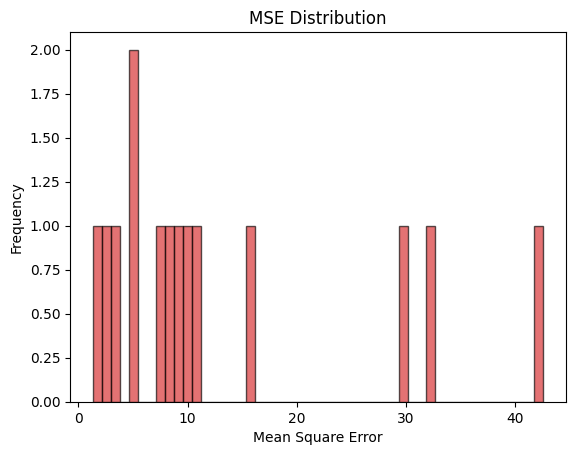

In [21]:
# Visualize MSE dbn for outliers 
plt.hist(mse_abn2,bins=50,color='C3',edgecolor='k', alpha=0.65)
plt.title('MSE Distribution')
plt.xlabel('Mean Square Error')
plt.ylabel('Frequency');
plt.savefig("MSE distribution for outliers only LS.tiff", dpi=300)

In [22]:
abn_pts2=X_abn_n[np.where(mse_abn2>=mse_th)] # Find where MSE outliers LS > MSE threshold from inliers

latent_space2=[]
for i in range(abn_pts2.shape[0]):
  test_abn=torch.tensor(abn_pts2[i]).to(device)
  lat=model.encoder(test_abn).detach().cpu().numpy()
  latent_space2.append(lat)
  
latent_space2=np.array(latent_space2)

Visualize the synthetic datapoints used to train the AE in the latent space as "inliers", while the abnormal points generated and encoded into the same latent space is "noise". Also, the MSE identified outlier points using the threshold/cut-off method is dubbed as "MSE Outliers"

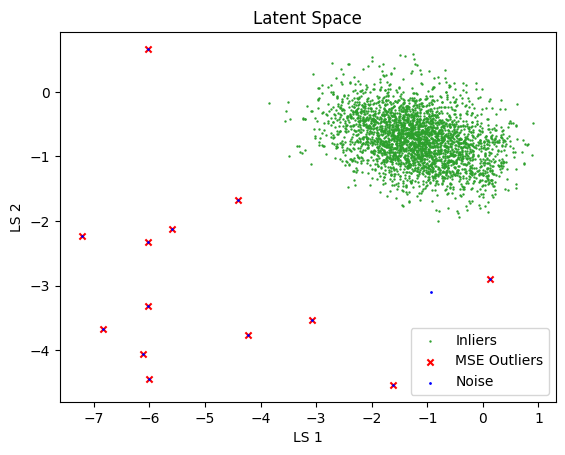

In [23]:
# Visualize both inliers, noise, and MSE outliers
plt.title('Latent Space')
plt.scatter(latent_space[:,0],latent_space[:,1],s=0.5,color='C2',label='Inliers')
plt.scatter(latent_space2[:,0],latent_space2[:,1],s=20,color='red',label='MSE Outliers', marker = 'x')
plt.scatter(abn_latent_space2[:,0],abn_latent_space2[:,1],s=1,color='blue',label='Noise', marker = 'o')

plt.legend()
plt.xlabel('LS 1')
plt.ylabel('LS 2');

To show the limitations of the MSE threshold method for outlier identification in the latent space, we curate new multidimensional datasets to show its sensitivity in outlier identification by changing the location and scale values of the abnormal points to be encoded in the latent space.

In [24]:
# Curate data to show sensitivity in outlier identification using MSE threshold approach for different location and scale values of a  multidimensional dataset
means = [1, 2, 3, 4, 5]
stdevs = [1, 3, 5, 7, 9]

abn_latent_space_by_params = {} # dictionary to store abn_latent_space2 arrays for each mean and stdev for all 5 outlier cases
mse_latent_space_by_params = {} # dictionary to store mse filtered latent space for each mean and stdev

for mean_val in means:
    abn_latent_space_by_params[mean_val] = {} # create a sub-dictionary for each mean value
    for stdev_val in stdevs:
        abn_latent_space2_list = [] # list to store abn_latent_space2 arrays for 25 realizations
        for i in range(25):
            # Make outlier points in the LS for points greater than the LS MSE threshold 
            # np.random.seed (73073) # set seed
            X_abn = np.random.normal(loc=mean_val, scale=stdev_val, size=100).reshape(-1,4)
            X_abn_n=norm_2(X_abn,X)


            abn_latent_space2=[]
            mse_abn2=[]
            for i in range(X_abn_n.shape[0]):
              test_abn=torch.tensor(X_abn_n[i]).to(device)

              lat=model.encoder(test_abn).detach().cpu().numpy()
              abn_latent_space2.append(lat)

              pred=model(test_abn).detach().cpu().numpy()
              inv_pred=inv_norm(pred,X)
              inv_test=inv_norm(X_abn_n[i],X)

              mse=mean_squared_error(inv_test,inv_pred)
              mse_abn2.append(mse)

            abn_latent_space2=np.array(abn_latent_space2)
            mse_abn2=np.array(mse_abn2)

            abn_latent_space2_list.append(abn_latent_space2)

        # # Visualize MSE dbn for outliers in each realization
        # plt.figure()
        # plt.hist(mse_abn2,bins=50,color='C3',edgecolor='k', alpha=0.65)
        # plt.title(f"MSE Distribution for case: mean {mean_val} and stdev {stdev_val}")
        # plt.xlabel('Mean Square Error')
        # plt.ylabel('Frequency');
        # plt.savefig("MSE Histograms for all LS.tiff", dpi=300)
        # plt.show()

        # Obtain the outliers in the AE LS
        abn_pts2=X_abn_n[np.where(mse_abn2>=mse_th)] # Find where MSE outliers LS > MSE threshold from inliers

        latent_space2=[]
        for i in range(abn_pts2.shape[0]):
          test_abn=torch.tensor(abn_pts2[i]).to(device)
          lat=model.encoder(test_abn).detach().cpu().numpy()
          latent_space2.append(lat)
          
        latent_space2=np.array(latent_space2)

        # Save LS and outliers for each case to a dictionary
        abn_latent_space_by_params[f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'] = abn_latent_space2 # all points
        mse_latent_space_by_params[f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'] = latent_space2 # MSE outliers

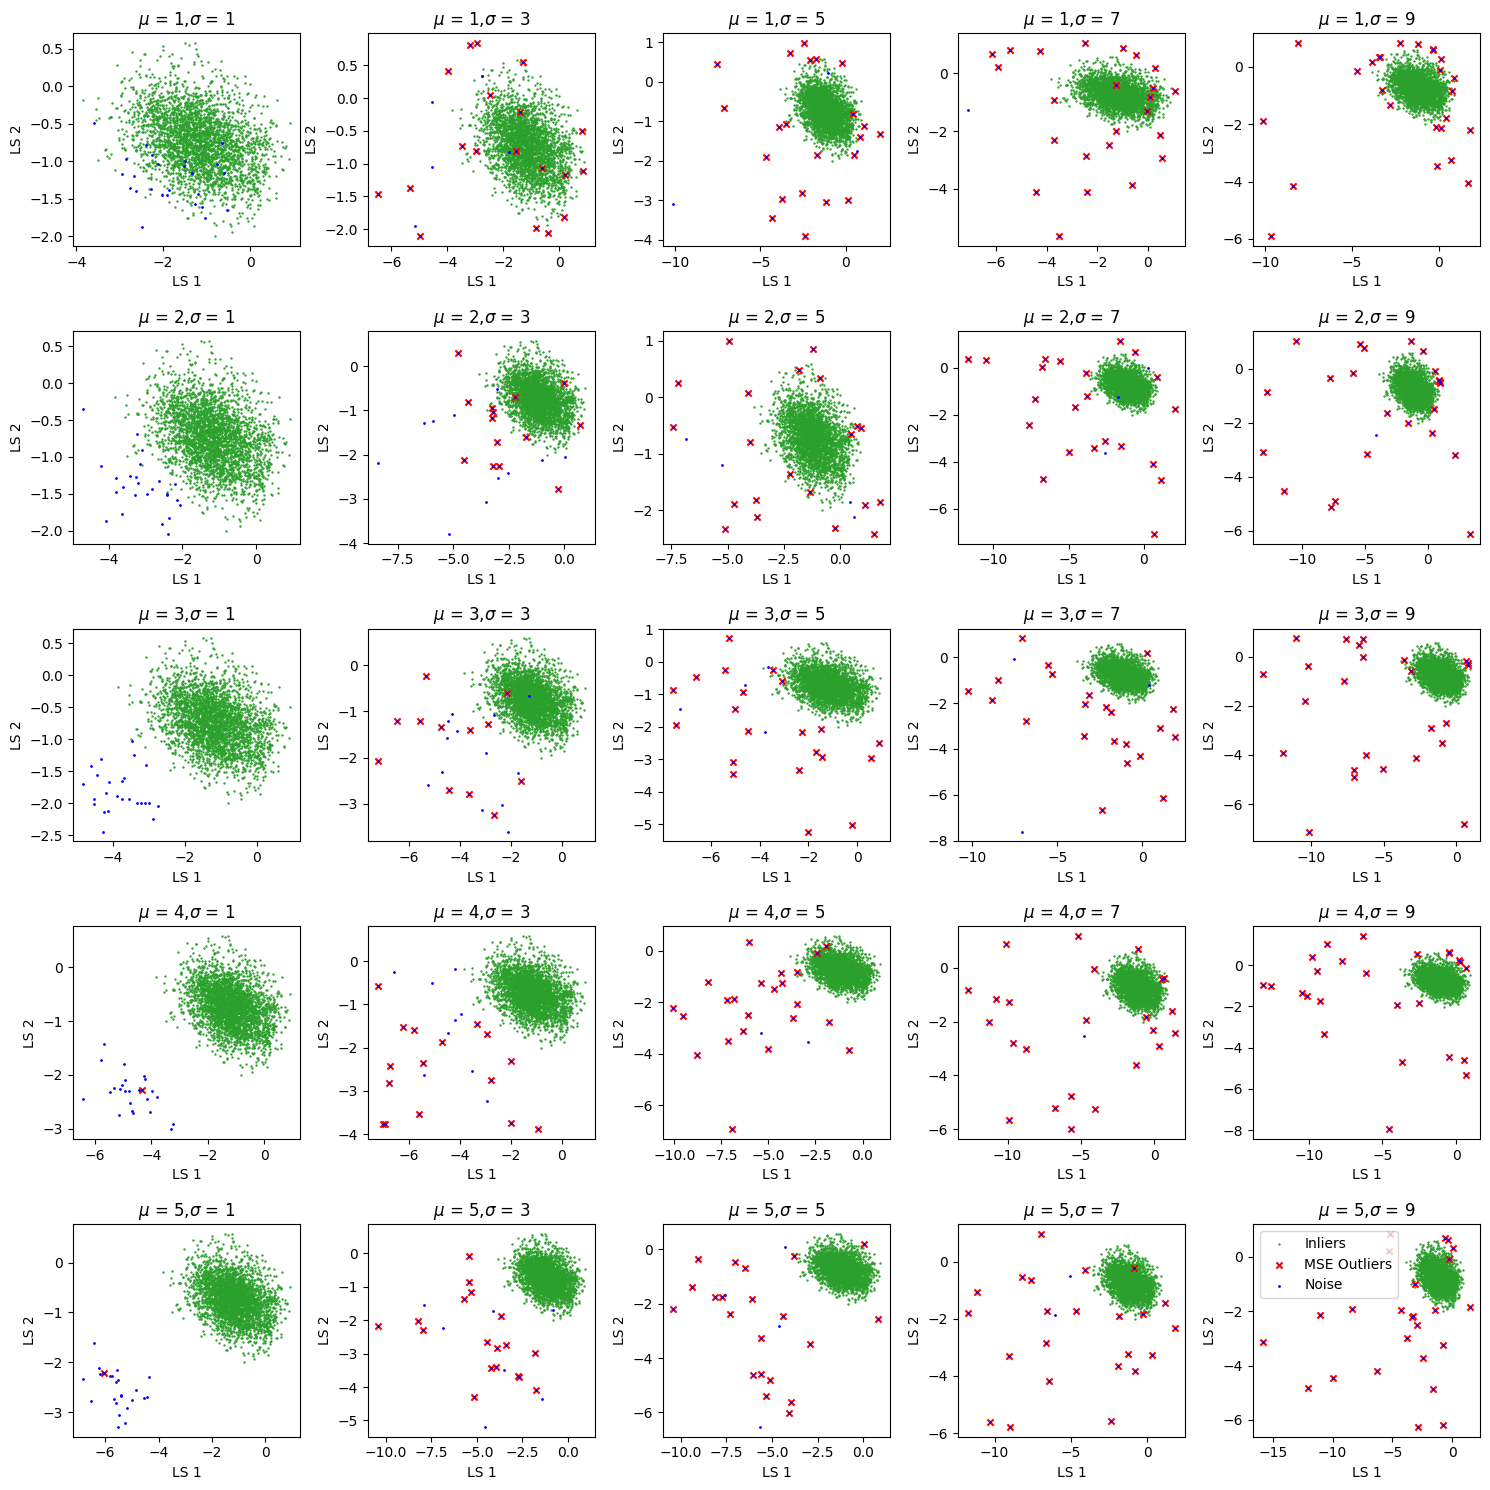

In [25]:
## Make visual for sensitivity of means and scales in MSE determined outliers
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        abn_latent_space = abn_latent_space_by_params[key]
        mse_latent_space = mse_latent_space_by_params[key]

        axs[i][j].scatter(latent_space[:,0],latent_space[:,1],s=0.5,color='C2',label='Inliers')
        if mse_latent_space.shape[0] == 0:
            axs[i][j].scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=1,color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering

        else:
            axs[i][j].scatter(mse_latent_space[:, 0], mse_latent_space[:, 1], s=20,color='red',label='MSE Outliers', marker = 'x') # with MSE filtering 
            axs[i][j].scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=1,color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
        axs[i][j].set_title(key)
        # axs[i][j].set_xticks([])
        # axs[i][j].set_yticks([])
        axs[i][j].set_xlabel('LS 1')
        axs[i][j].set_ylabel('LS 2')

axs[i][j].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("MSE outlier identification in LS.tiff", dpi=300)
plt.show()

Curate the datasets to the right format for our proposed outlier identification method (AE-DBSCAN) and existing methodologies in literature such as Isolation Forest, DBSCAN on high dimensional data, and Local outlier Factor methods.

In [26]:
all_latent_space_by_params = {} # create a dictionary to store all_latent_space arrays

# Curate data for DBSCAN and other outlier detection methods 
for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        abn_latent_space = abn_latent_space_by_params[key] # without filtering
        all_latent_space = np.concatenate((latent_space, abn_latent_space), axis=0) # where latent space is the std normal dbn
        all_latent_space_by_params[key] = all_latent_space # store all_latent_space array with the corresponding key

# Save disctionary for all LS to file
with open("all_latent_space.pickle", "wb") as f:
    # dump the dictionary to the file using pickle.dump()
    pickle.dump(all_latent_space_by_params, f)

# AE-DBSCAN for Outlier Identification in Multidimensional Tabular datasets

First, we obtain the epsilon value parameter for DBSCAN from the nearest neighbor plot of the latent space. Where the eps parameter is found to be the point of maximum curvature from the curve.

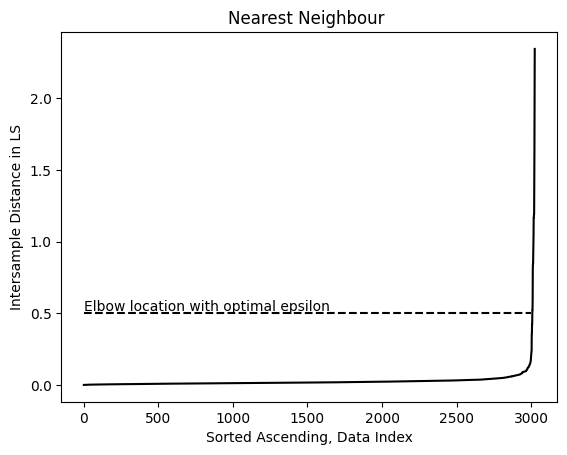

In [27]:
# Obtain epsilon values for each  realization case if we want to plot it. 
key = f'$\mu$ = {2},$\sigma$ = {7}'
all_latent_space_ = all_latent_space_by_params[key]

elbow = nearest_neighbor(all_latent_space_, [0, 3000], [0.5, 0.5], [0.52,0.52], plotter=True)

Let's tune the DBSCAN in the latent space over the 25 realizations obtained using AE-MSE to enable apples to apples comparison.

First, we tune on a column basis, i.e. the same eps and min sample parameter is used on generated abnormal datasets with the same standard deviation for all changing mean values. The parameters were tuned this way as we found that the variability in the means leads to more sensitivity during outlier determination.

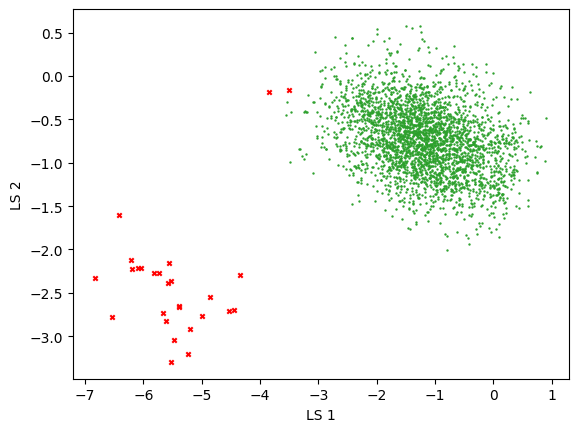

In [28]:
# DBSCAN tuning at stdev = 1 for every mean value in the abnormal point generated 

# select example key
key = f'$\mu$ = {5},$\sigma$ = {1}'
all_latent_space_col1 = all_latent_space_by_params[key]
abn_latent_space = abn_latent_space_by_params[key] # contains all noise

n_clusters = []
df = pd.DataFrame(all_latent_space_col1, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.315, min_samples=10).fit(df.values)
df['Label'] = dbscan.labels_ + 1

plt.subplot(111)
df_in = df.loc[(df['Label'] != 0)]
df_outlier = df.loc[(df['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())
n_clusters.append(number_clusters)

plt.scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=0.5, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5) # dbscan inlier
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='x') # dbscan outlier


plt.xlabel('LS 1')
plt.ylabel('LS 2')
plt.show()

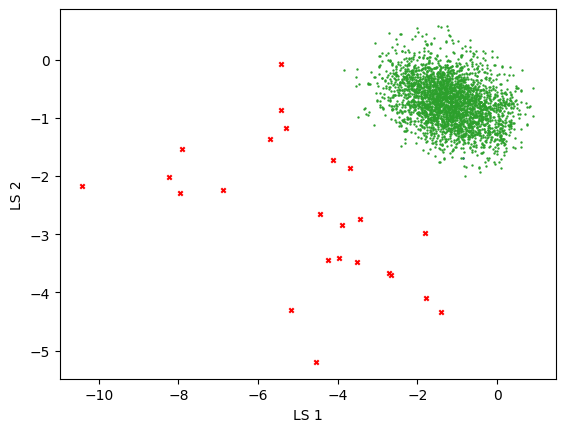

In [29]:
# DBSCAN tuning at stdev = 3 for every mean value in the abnormal point generated 

# select example key
key = f'$\mu$ = {5},$\sigma$ = {3}'
all_latent_space_col2 = all_latent_space_by_params[key]
abn_latent_space = abn_latent_space_by_params[key] # contains all noise

n_clusters = []
df = pd.DataFrame(all_latent_space_col2, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(df.values) # Parameter works for all means at this stdev
df['Label'] = dbscan.labels_ + 1

plt.subplot(111)
df_in = df.loc[(df['Label'] != 0)]
df_outlier = df.loc[(df['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())
n_clusters.append(number_clusters)

plt.scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=0.5, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5)
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='x')

plt.xlabel('LS 1')
plt.ylabel('LS 2')
plt.show()

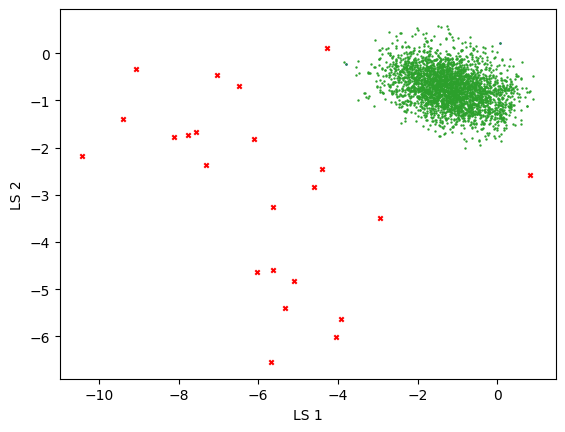

In [30]:
# DBSCAN tuning at stdev = 5 for every mean value in the abnormal point generated 

# select example key
key = f'$\mu$ = {5},$\sigma$ = {5}'
all_latent_space_col3 = all_latent_space_by_params[key]
abn_latent_space = abn_latent_space_by_params[key] # contains all noise

n_clusters = []
df = pd.DataFrame(all_latent_space_col3, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(df.values) # Parameter works for all means at this stdev
df['Label'] = dbscan.labels_ + 1

plt.subplot(111)
df_in = df.loc[(df['Label'] != 0)]
df_outlier = df.loc[(df['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())
n_clusters.append(number_clusters)

plt.scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=0.5, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5)
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='x')


plt.xlabel('LS 1')
plt.ylabel('LS 2')
plt.show()

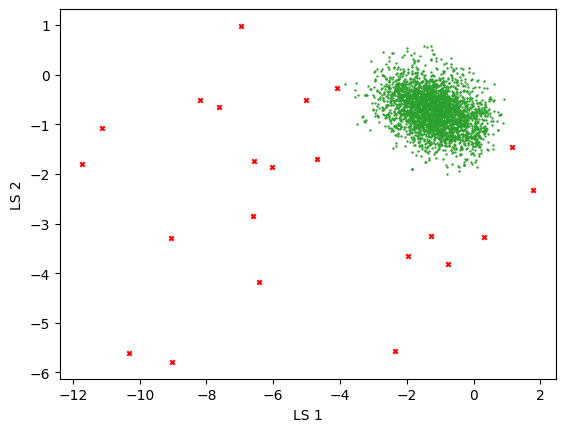

In [31]:
# DBSCAN tuning at stdev = 7 for every mean value in the abnormal point generated 

# select example key
key = f'$\mu$ = {5},$\sigma$ = {7}'
all_latent_space_col4 = all_latent_space_by_params[key]
abn_latent_space = abn_latent_space_by_params[key] # contains all noise

n_clusters = []
df = pd.DataFrame(all_latent_space_col4, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(df.values) # Parameter works for all means at this stdev
df['Label'] = dbscan.labels_ + 1

plt.subplot(111)
df_in = df.loc[(df['Label'] != 0)]
df_outlier = df.loc[(df['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())
n_clusters.append(number_clusters)

plt.scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=0.5, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5)
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='x')

plt.xlabel('LS 1')
plt.ylabel('LS 2')
plt.show()

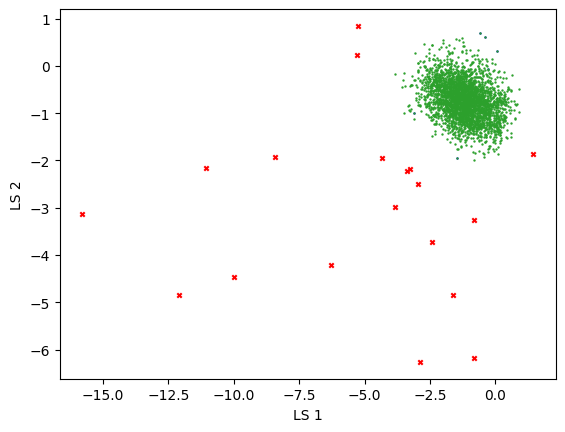

In [32]:
# DBSCAN tuning at stdev = 9 for every mean value in the abnormal point generated 

# select example key
key = f'$\mu$ = {5},$\sigma$ = {9}'
all_latent_space_col5 = all_latent_space_by_params[key]
abn_latent_space = abn_latent_space_by_params[key] # contains all noise

n_clusters = []
df = pd.DataFrame(all_latent_space_col5, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(df.values) # Parameter works for all means at this stdev
df['Label'] = dbscan.labels_ + 1

plt.subplot(111)
df_in = df.loc[(df['Label'] != 0)]
df_outlier = df.loc[(df['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())
n_clusters.append(number_clusters)

plt.scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=0.5, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5)
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='x')

plt.xlabel('LS 1')
plt.ylabel('LS 2')
plt.show()

Now that we have tuned the paramters for DBSCAN and obtained the optimal params for each colum let's create an array with these results so we can plot the sensitivity of this approach to changes in the mean and stdev using the 5x5 subplots yielding 25 realizations

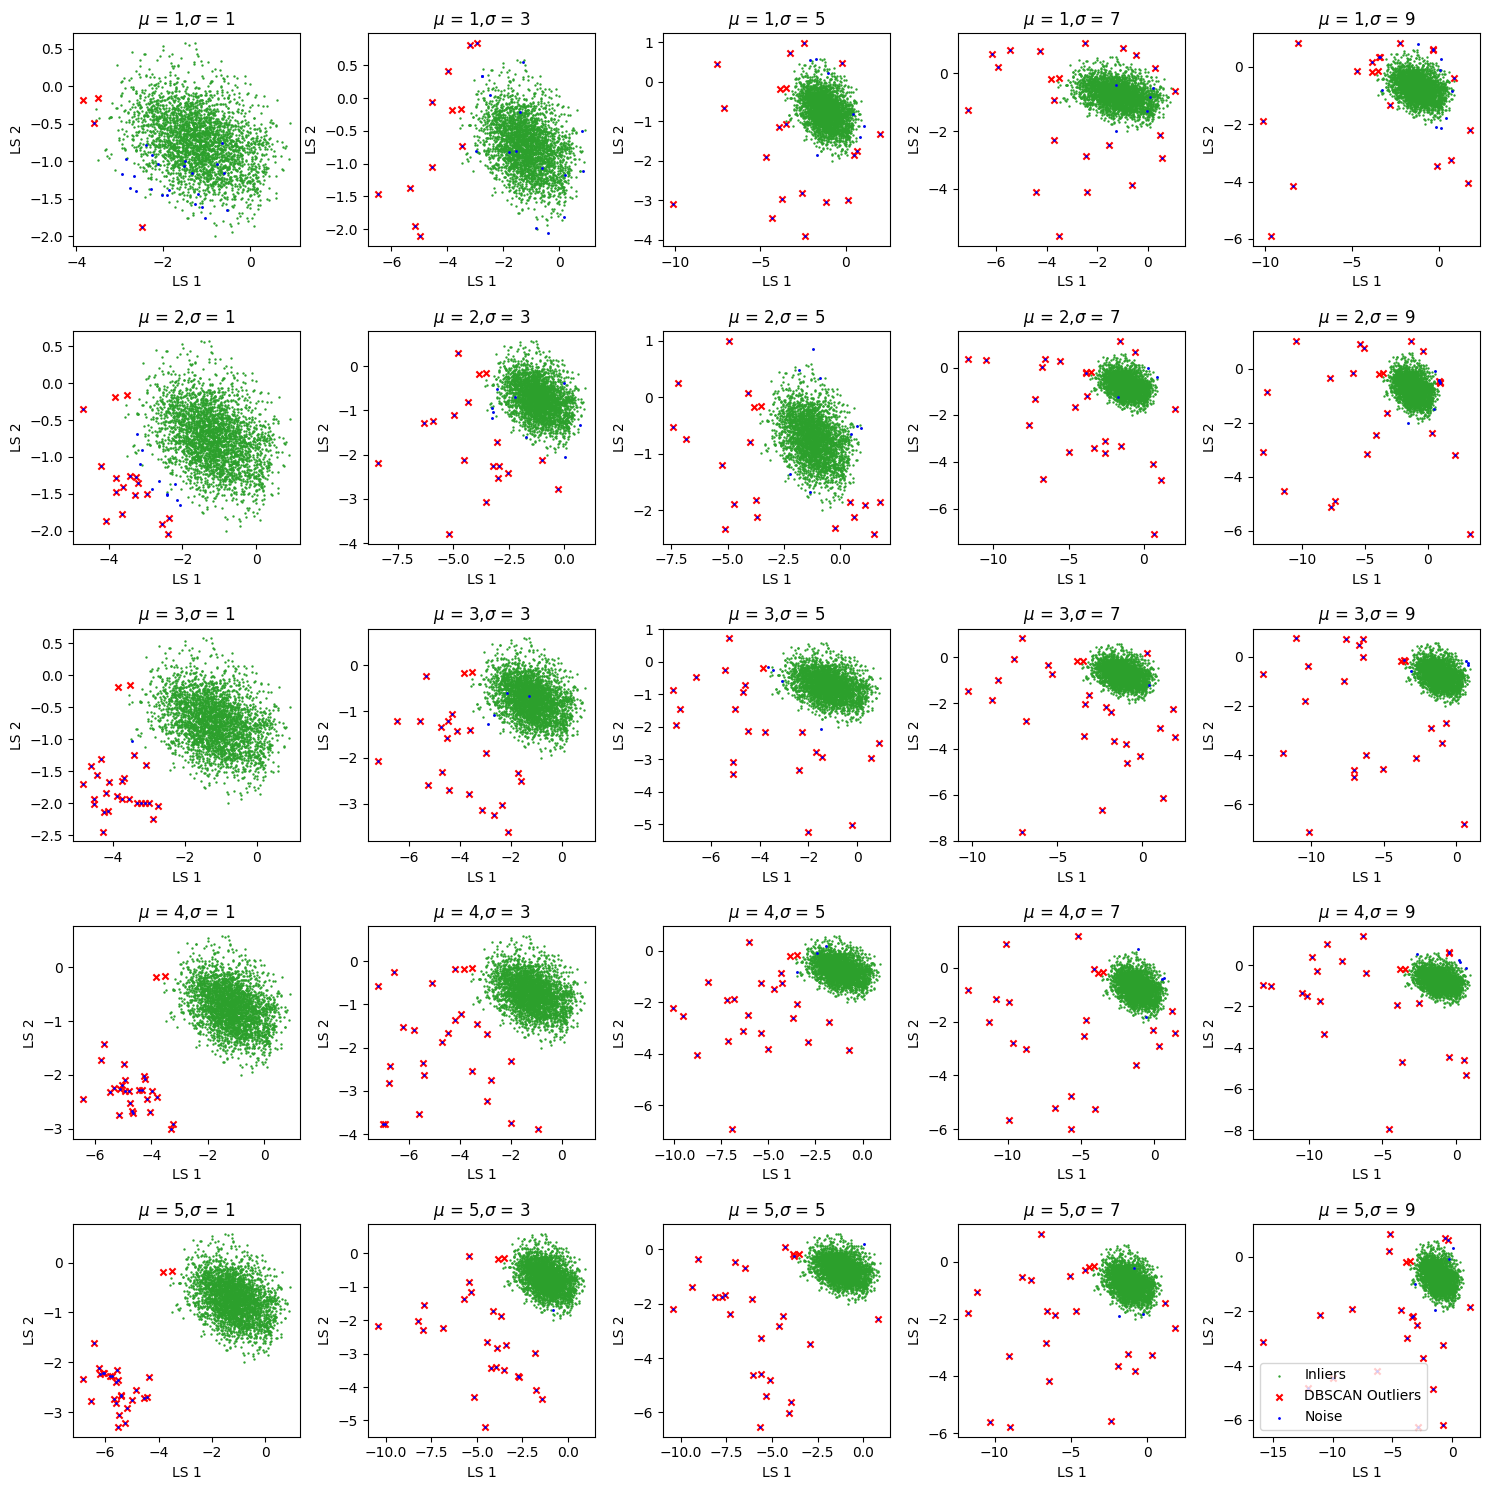

In [33]:
# Make visual for sensitivity of means and scales in DBSCAN determined outliers
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

# Obtain each scenario from all latent space data in 5 by 5 sublplot
for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        all_latent_space = all_latent_space_by_params[key]
        abn_latent_space = abn_latent_space_by_params[key] # contains all noise added

        # Find clusters
        n_clusters = []
        df = pd.DataFrame(all_latent_space, columns=['LS 1', 'LS 2'])
        dbscan = DBSCAN(eps=0.315, min_samples=10).fit(df.values)
        df['Label'] = dbscan.labels_ + 1
        df_in = df.loc[(df['Label'] != 0)]
        df_outlier = df.loc[(df['Label'] == 0)]
        number_clusters = len(df_in['Label'].unique())
        n_clusters.append(number_clusters)

        # Make visual
        axs[i][j].scatter(df_in.iloc[:, 0], df_in.iloc[:, 1],s=0.5,color='C2',label='Inliers')
        axs[i][j].scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], s=20, color='red',label='DBSCAN Outliers', marker = 'x')
        axs[i][j].scatter(abn_latent_space[:, 0], abn_latent_space[:, 1], s=1, color='blue',label='Noise', marker = 'o') # all abnormal samples without any form of filtering
        axs[i][j].set_title(key)
        # axs[i][j].set_xticks([])
        # axs[i][j].set_yticks([])
        axs[i][j].set_xlabel('LS 1')
        axs[i][j].set_ylabel('LS 2')

axs[i][j].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("DBSCAN outlier identification in LS.tiff", dpi=300)
plt.show()

# Existing Multivariate Outlier Detection Methodologies

<br>

Let's perform some of the existing methods in literature that works on the identification of Multivariate outliers, but before we proceed let's use pca to reduce the dimension of the data to better aid visulaization of the outliers found using these methods.

1. Isolation Forest (IF)
2. DBSCAN on highdimensional dataset
3. Local outlier factor (LOF)

<br>

For the three methods above, since they are performed on high dimensional dataasts in their original space, visualization is a problem. Hence, we used principal component analysis to reduce the dimensionality to enable visualization using the two most prominent principal component found i.e., PC 1 and PC 2.

## Isolation Forest (IF)

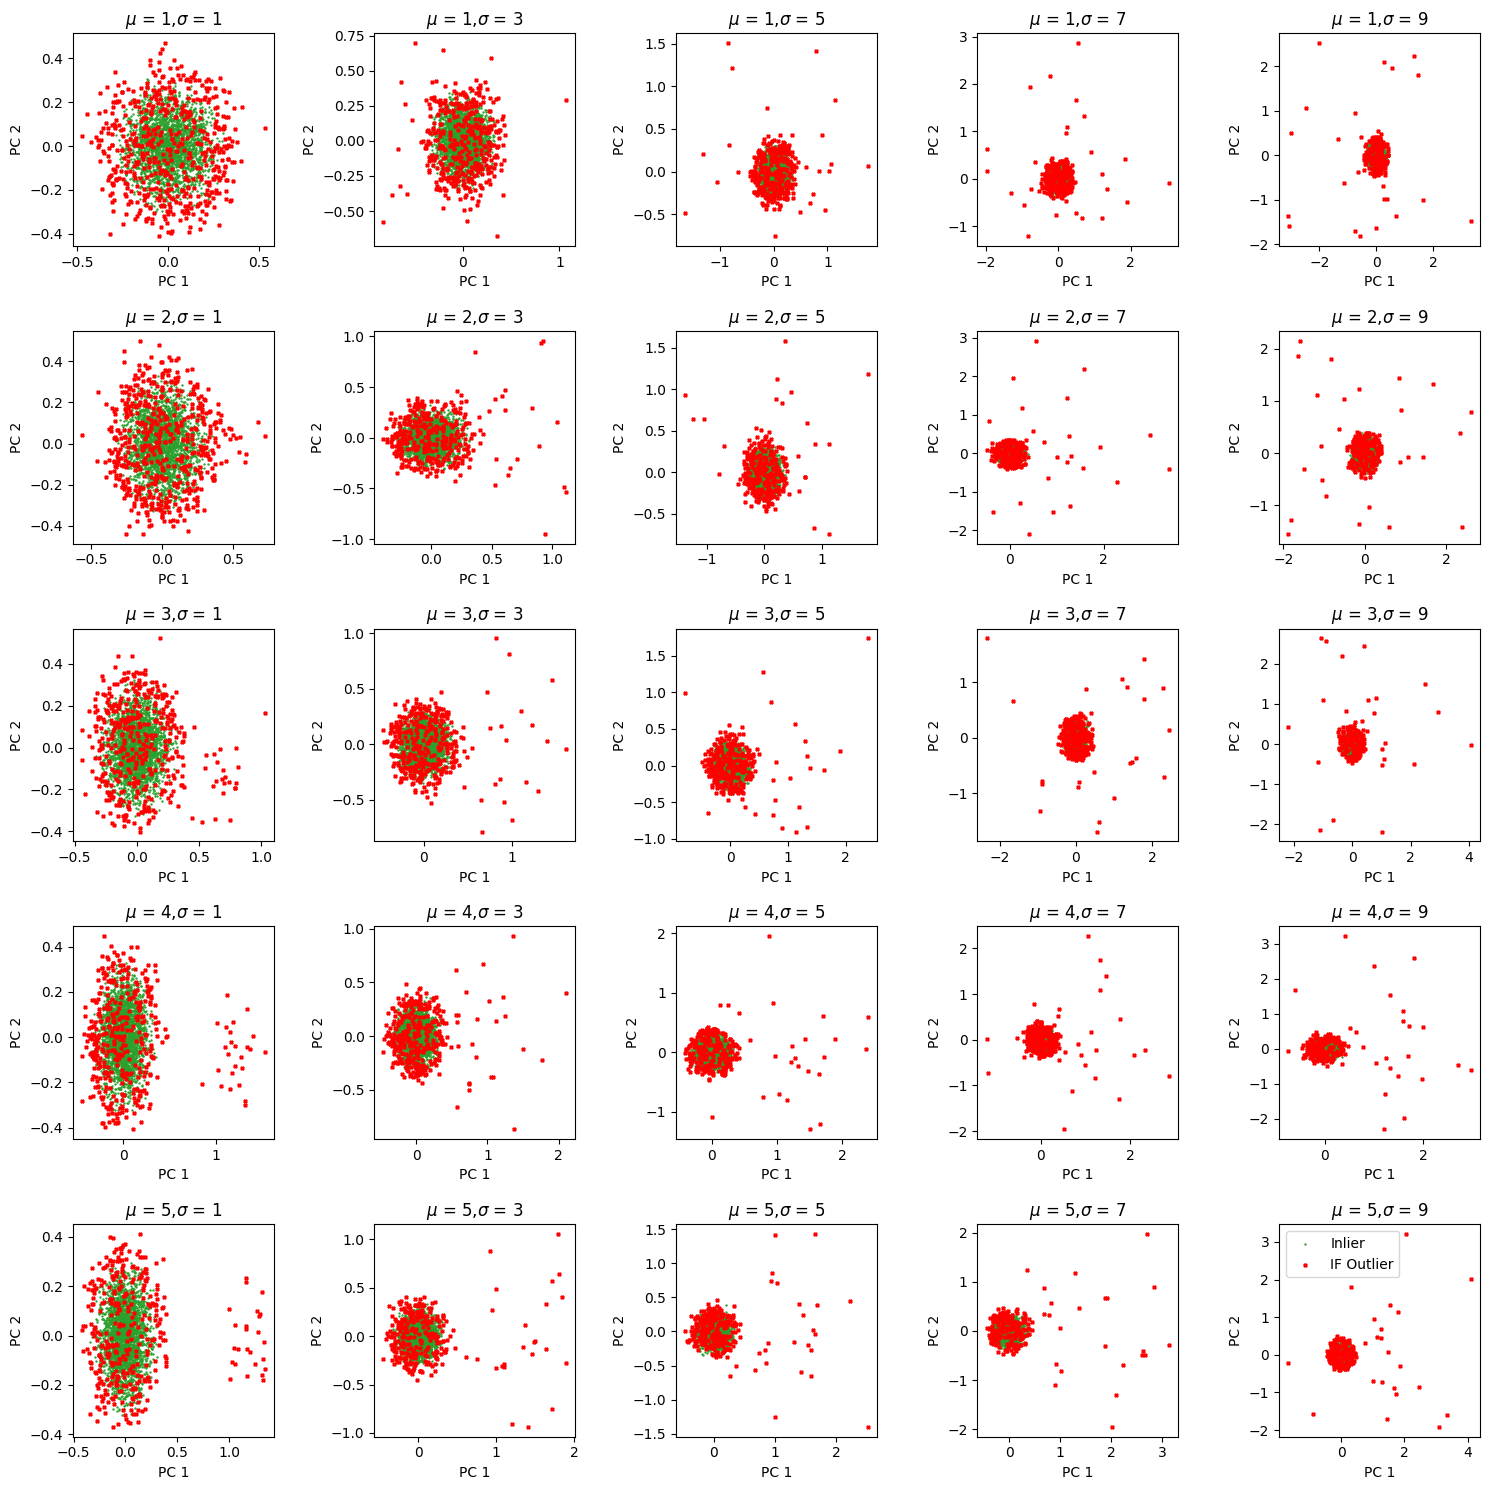

In [34]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

# Obtain each scenario from all latent space data in 5 by 5 sublplot
for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        # Make outlier points in the LS for points greater than the LS MSE threshold 
        # np.random.seed (73073) # set seed
        X_abn = np.random.normal(loc=mean_val, scale=stdev_val, size=100).reshape(-1,4) # for euclidean space noise
        X_abn_n=norm_2(X_abn,X) # For normalized space noise

        #np.random.seed (73073) # set seed
        X = np.random.normal(loc=0, scale=1, size=3000*4).reshape(-1,4) # Create a multidimensional from the same standard normal distribution randomly for four predictor features same as AE input
        X_n=norm(X) # Find the normalized version of the AE array input

        X_input = np.concatenate((X,X_abn), axis=0) # merge to obtain all data noise inclusive
        X_input_n = np.concatenate((X_n,X_abn_n), axis=0) # merge to obtain aall data inclusive of noise but normalized

        # Dimensionality reduction to 2 dimensions via PCA
        pca = PCA(n_components=2) 
        real_pca = pca.fit_transform(X_input_n) # use normalized data
        
        # Isolation forest
        isolation = IsolationForest(n_estimators=200, 
                            contamination='auto', 
                            max_features=X_input.shape[1], random_state=42)
        
        # Fit and predict
        isolation.fit(X_input)
        outliers_predicted = isolation.predict(X_input)

        # Make dataframe to keep values
        df_IF = pd.DataFrame(X_input)

        # Add outliers to new column
        df_IF['outlier'] = outliers_predicted

        # Add PC 1 and PC 2 to the df
        df_IF['PC 1'] = real_pca[:,0]
        df_IF['PC 2'] = real_pca[:,1]

        # How many outliers exist in the dataset
        df_IF['outlier'].value_counts() 

        # Curate inliers and outliers per IF method
        inliers = df_IF[df_IF['outlier'] == 1]
        outliers = df_IF[df_IF['outlier'] != 1]

        # Visualize PCA projections
        #axs[i][j].scatter(real_pca[:, 0], real_pca[:, 1],s=0.5, color='gray',label='All samples')
        axs[i][j].scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
        axs[i][j].scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=5, marker='X',label='IF Outlier')

        axs[i][j].set_title(key)
        # axs[i][j].set_xticks([])
        # axs[i][j].set_yticks([])
        axs[i][j].set_xlabel('PC 1')
        axs[i][j].set_ylabel('PC 2')

axs[i][j].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.savefig("PCA and IF in original space.tiff", dpi=300)
plt.show()   

## DBSCAN in High Dimensional Space



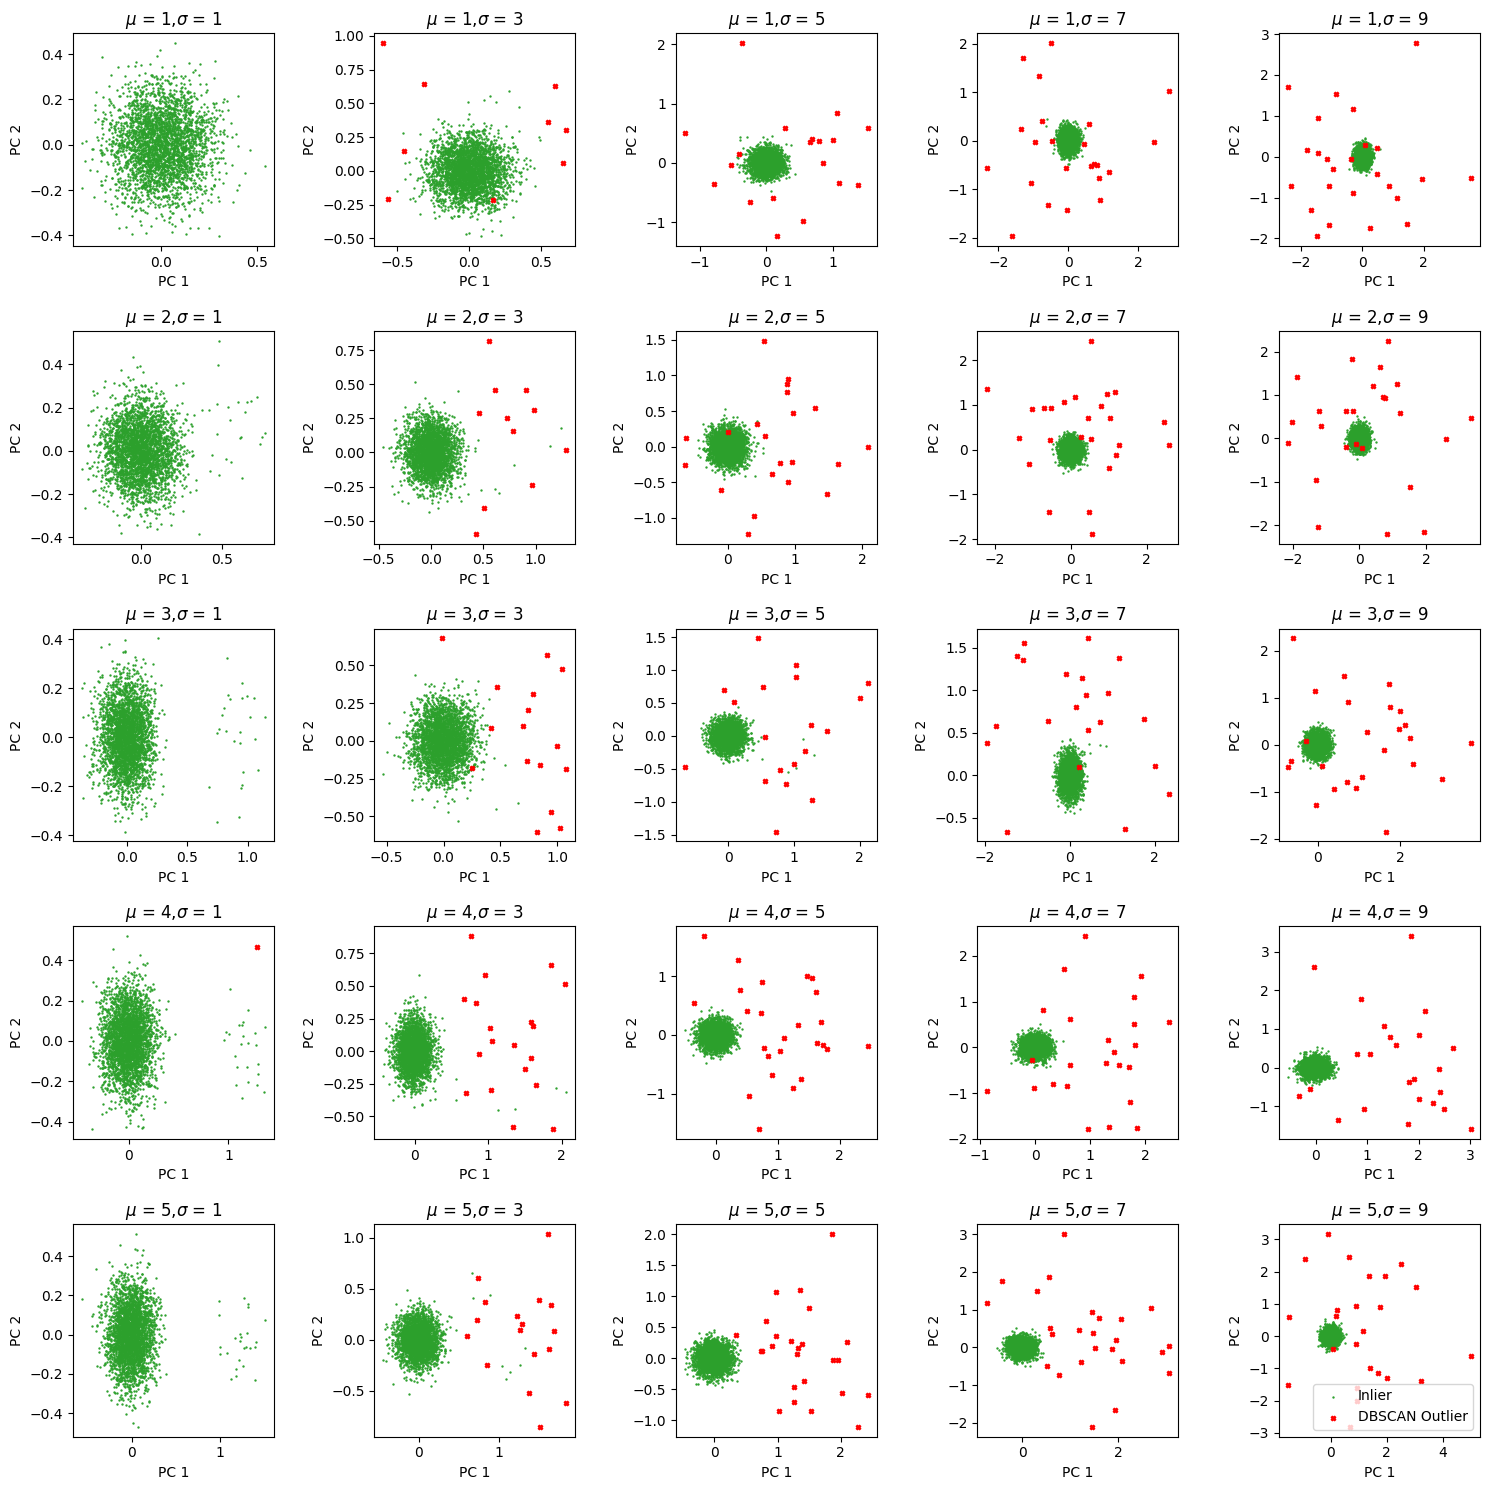

In [35]:
# DBSCAN in high dimensional space
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

n_clusters = []
# Obtain each latent space scenario from all latent space data in 5 by 5 sublplot
for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        # Make outlier points in the LS for points greater than the LS MSE threshold 
        # np.random.seed (73073) # set seed
        X_abn = np.random.normal(loc=mean_val, scale=stdev_val, size=100).reshape(-1,4) # for euclidean space noise
        X_abn_n=norm_2(X_abn,X) # For normalized space noise

        #np.random.seed (73073) # set seed
        X = np.random.normal(loc=0, scale=1, size=3000*4).reshape(-1,4) # Create a multidimensional from the same standard normal distribution randomly for four predictor features same as AE input
        X_n=norm(X) # Find the normalized version of the AE array input

        X_input = np.concatenate((X, X_abn), axis=0) # merge to obtain all data noise inclusive
        X_input_n = np.concatenate((X_n,X_abn_n), axis=0) # merge to obtain aall data inclusive of noise but normalized

        # Dimensionality reduction to 2 dimensions via PCA
        pca = PCA(n_components=2) 
        real_pca = pca.fit_transform(X_input_n) # use normalized data
        
        # Make dataframe to keep values
        df_DBSCAN = pd.DataFrame(X_input_n) # scaled data used as input here

       
       # Instantiate DBSCAN
        dbscan = DBSCAN(eps=0.315, min_samples=2).fit(df_DBSCAN.values)
        df_DBSCAN['DB-Label'] = dbscan.labels_ + 1

        # Add PC 1 and PC 2 to the df
        df_DBSCAN['PC 1'] = real_pca[:,0]
        df_DBSCAN['PC 2'] = real_pca[:,1]

        # Separate inlier and outliers
        inliers = df_DBSCAN.loc[(df_DBSCAN['DB-Label'] != 0)]
        outliers = df_DBSCAN.loc[(df_DBSCAN['DB-Label'] == 0)]
        number_clusters = len(inliers['DB-Label'].unique())
        n_clusters.append(number_clusters)


        # How many outliers exist in the dataset
        outliers['DB-Label'].value_counts() 

        # Visualize PCA projections
        #axs[i][j].scatter(real_pca[:, 0], real_pca[:, 1],s=0.5, color='gray',label='All samples')
        axs[i][j].scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
        axs[i][j].scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=10, marker='X',label='DBSCAN Outlier')

        axs[i][j].set_title(key)
        # axs[i][j].set_xticks([])
        # axs[i][j].set_yticks([])
        axs[i][j].set_xlabel('PC 1')
        axs[i][j].set_ylabel('PC 2')

axs[i][j].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.savefig("PCA and DBSCAN in original space.tiff", dpi=300)
plt.show()   

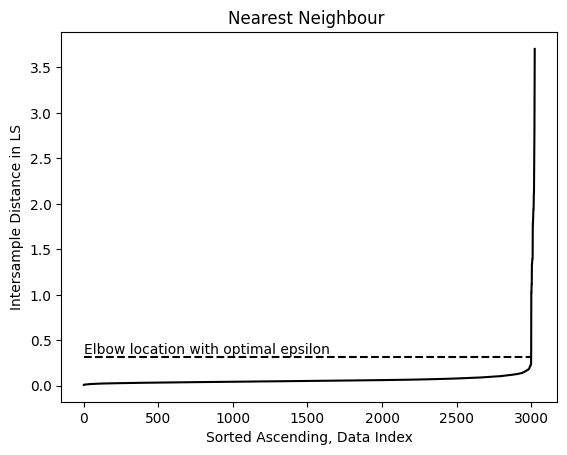

In [36]:
 elbow = nearest_neighbor(df_DBSCAN.values ,[0, 3000], [0.315, 0.315], [0.35,0.35], plotter=True) # visual verification for tuned dbscan parameter values used above

## Local Outlier Factor (LOF)

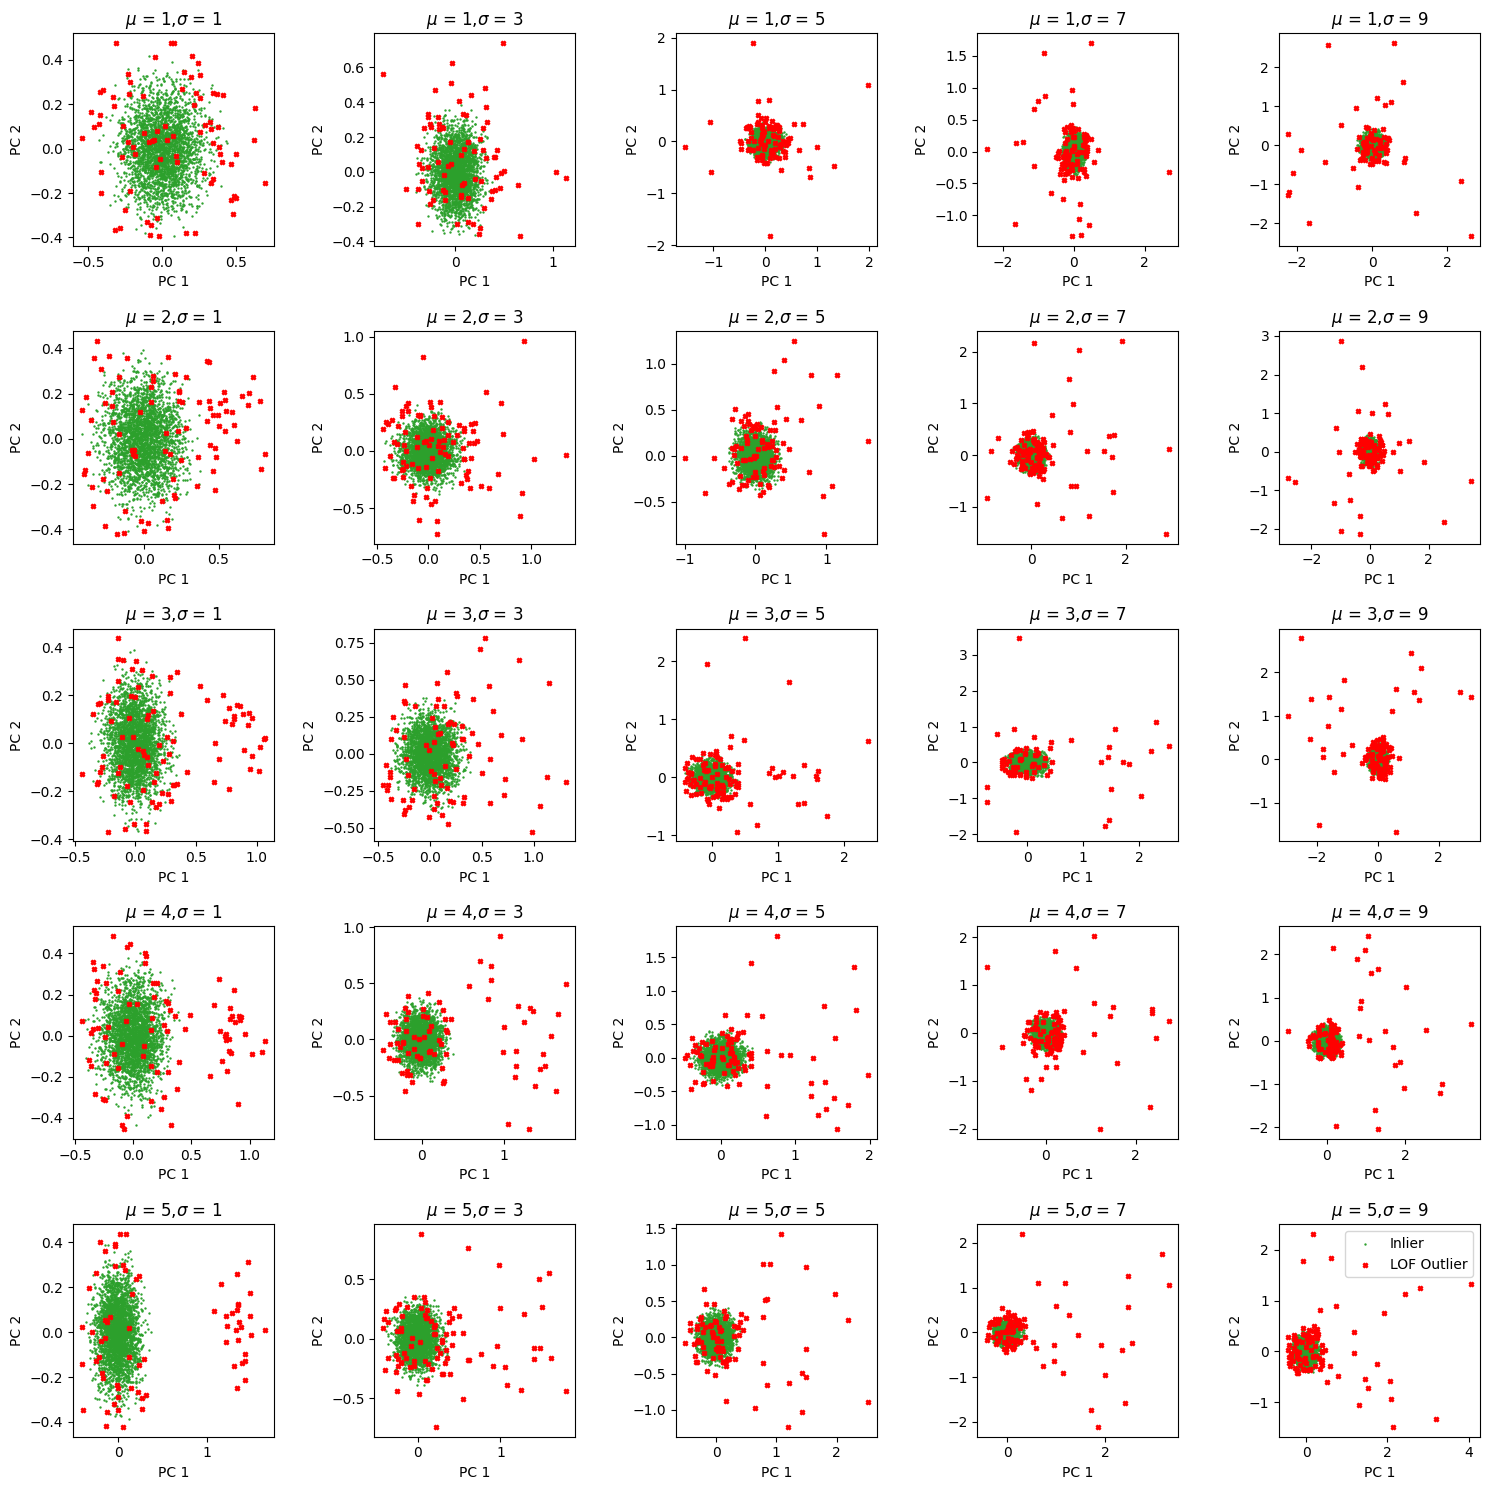

In [37]:
# Local outlier factor method, LOF
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

# Obtain each latent space scenario from all latent space data in 5 by 5 sublplot
for i, mean_val in enumerate(means):
    for j, stdev_val in enumerate(stdevs):
        key = f'$\mu$ = {mean_val},$\sigma$ = {stdev_val}'
        # Make outlier points in the LS for points greater than the LS MSE threshold 
        # np.random.seed (73073) # set seed
        X_abn = np.random.normal(loc=mean_val, scale=stdev_val, size=100).reshape(-1,4) # for euclidean space noise
        X_abn_n=norm_2(X_abn,X) # For normalized space noise

        #np.random.seed (73073) # set seed
        X = np.random.normal(loc=0, scale=1, size=3000*4).reshape(-1,4) # Create a multidimensional from the same standard normal distribution randomly for four predictor features same as AE input
        X_n=norm(X) # Find the normalized version of the AE array input

        X_input = np.concatenate((X,X_abn), axis=0) # merge to obtain all data noise inclusive
        X_input_n = np.concatenate((X_n,X_abn_n), axis=0) # merge to obtain aall data inclusive of noise but normalized

        # Dimensionality reduction to 2 dimensions via PCA
        pca = PCA(n_components=2) 
        real_pca = pca.fit_transform(X_input_n) # use normalized data
        

        # Make dataframe to keep values
        df_lof = pd.DataFrame(X_input_n) # scaled data used as input here

       # Instantiate LOF
        lof = LocalOutlierFactor(n_neighbors=200, contamination='auto')

        # Fit and predict on scaled data
        outliers_predicted = lof.fit_predict(df_lof)

        # Add outliers to new column
        df_lof['outlier'] = outliers_predicted

        # Add PC 1 and PC 2 to the df
        df_lof['PC 1'] = real_pca[:,0]
        df_lof['PC 2'] = real_pca[:,1]

        # How many outliers exist in the dataset
        df_lof['outlier'].value_counts() 

        # Curate inliers and outliers per IF method
        inliers = df_lof[df_lof['outlier'] == 1]
        outliers = df_lof[df_lof['outlier'] != 1]

        # Visualize PCA projections
        #axs[i][j].scatter(real_pca[:, 0], real_pca[:, 1],s=0.5, color='gray',label='All samples')
        axs[i][j].scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
        axs[i][j].scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=10, marker='X',label='LOF Outlier')

        axs[i][j].set_title(key)
        # axs[i][j].set_xticks([])
        # axs[i][j].set_yticks([])
        axs[i][j].set_xlabel('PC 1')
        axs[i][j].set_ylabel('PC 2')

axs[i][j].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.savefig("PCA and LOF in original space.tiff", dpi=300)
plt.show()   